In [1]:
 cd ..

/


In [0]:
mkdir root/.kaggle


In [0]:
api_token = {"username":"amarlatchireddy","key":"d1927120ebdf3ead33a9cda469c43340"}
import json
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
mkdir knn_amazon

In [5]:
cd knn_amazon


/knn_amazon


In [6]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 99% 239M/242M [00:03<00:00, 53.7MB/s]
100% 242M/242M [00:03<00:00, 76.4MB/s]


In [7]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [9]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head()

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>4
""", con)

In [11]:
print(display.shape)
display.head()

(23593, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,A1001WMV1CL0XH,B005DGI1VG,Corey DePaul,1345334400,5,We have two small Maltese and they absolutely ...,6
1,A10023OS6MZUC6,B000N9YF4K,Wilton Dubois,1274400000,5,This seasoning is great! It makes a store bou...,5
2,A1004703RC79J9,B003XDH6M6,Dean Burns,1313712000,4,I've read several reviews complaining about th...,7
3,A100IC7JRCQDUD,B000CQID1K,"Joel Elmer Coldwater III ""Research For The Best""",1307923200,5,"If you like slim Jims, you will like 100 slim ...",7
4,A100UZGZNZ9ZYN,B0030F70HI,"Nomadic PC User ""Chef""",1282089600,1,"Maybe what the box claims is true, no additive...",8


In [12]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
23586,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [13]:
display['COUNT(*)'].sum()#total no.of duplicates

243907

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [16]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [17]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

In [18]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [19]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

In [21]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [22]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [23]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [26]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [27]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [29]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3113.21it/s]


In [30]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [31]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


In [32]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
final_bigram_counts.shape

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


(4986, 3144)

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [35]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=300, workers=-1)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('butter', 0.19477292895317078), ('conscious', 0.1919802725315094), ('diamond', 0.18851527571678162), ('goodness', 0.1880270093679428), ('introduce', 0.18451115489006042), ('intolerant', 0.18414369225502014), ('cane', 0.18071040511131287), ('nutritional', 0.17337003350257874), ('slow', 0.17237722873687744), ('shame', 0.17106260359287262)]
[('recommendation', 0.19211694598197937), ('west', 0.17466460168361664), ('cream', 0.17312833666801453), ('sam', 0.16838820278644562), ('want', 0.16635151207447052), ('selection', 0.16634774208068848), ('jam', 0.16424159705638885), ('share', 0.16086819767951965), ('reply', 0.16078610718250275), ('grease', 0.15919539332389832)]


In [36]:
w2v_model.wv.similarity('taste','beef')

-0.032976333

In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:04<00:00, 1240.31it/s]

4986
300


In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:25<00:00, 193.66it/s]


In [0]:
ps=positiveNegative[0:4986]

In [0]:
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

xbow_train, xbow_test,ybow_train,ybow_test = train_test_split(final_counts,final['Score'], test_size = 0.3)#train test

In [0]:

xbw_tr,xbw_cv,ybw_tr,ybw_cv=train_test_split(xbow_train,ybow_train,test_size=0.3)#train into train and cv

In [44]:
cv_scores=[]
for i in range(1,40,2):
    knn=KNeighborsClassifier(n_neighbors=i ,algorithm='brute')#simple cross validation
    #simple cross validation+
    knn.fit(xbw_tr,ybw_tr)
    pred=knn.predict(xbw_cv)
    acc = accuracy_score(ybw_cv, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %f%%' % (i, acc))
knn = KNeighborsClassifier(15)
knn.fit(xbw_tr,ybw_tr)
pred = knn.predict(xbow_test)
acc = accuracy_score(ybow_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 9 is %d%%' % (acc))


CV accuracy for k = 1 is 77.077364%

CV accuracy for k = 3 is 81.088825%

CV accuracy for k = 5 is 81.661891%

CV accuracy for k = 7 is 81.757402%

CV accuracy for k = 9 is 82.043935%

CV accuracy for k = 11 is 81.948424%

CV accuracy for k = 13 is 82.043935%

CV accuracy for k = 15 is 82.043935%

CV accuracy for k = 17 is 82.330468%

CV accuracy for k = 19 is 82.043935%

CV accuracy for k = 21 is 82.043935%

CV accuracy for k = 23 is 81.948424%

CV accuracy for k = 25 is 82.139446%

CV accuracy for k = 27 is 82.139446%

CV accuracy for k = 29 is 82.139446%

CV accuracy for k = 31 is 82.139446%

CV accuracy for k = 33 is 82.234957%

CV accuracy for k = 35 is 82.234957%

CV accuracy for k = 37 is 82.139446%

CV accuracy for k = 39 is 82.043935%

****Test accuracy for k = 9 is 85%



The optimal number of neighbors is 19.


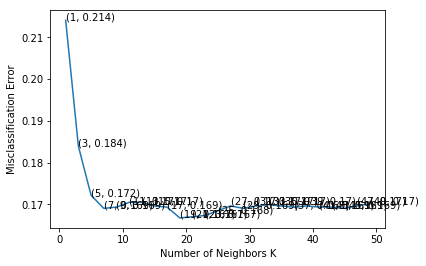

the misclassification error for each k value is :  [0.214 0.184 0.172 0.169 0.169 0.17  0.17  0.17  0.169 0.167 0.167 0.167
 0.168 0.17  0.169 0.17  0.17  0.17  0.169 0.17  0.169 0.169 0.169 0.17
 0.17 ]


In [45]:


# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cvs_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xbow_train, ybow_train, cv=3, scoring='accuracy')
    cvs_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cvs_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [46]:
from sklearn.metrics import roc_auc_score

auc_scores = []
train_auc_score = []

for i in range(1,100,2):
     knn=KNeighborsClassifier(n_neighbors=i)
    
     knn.fit(xbw_tr,ybw_tr)
     pred=knn.predict(xbw_tr)
     auc = roc_auc_score(ybw_tr, pred) * float(100)
     train_auc_score.append(auc)
     
     predcv=knn.predict(xbw_cv)
     auccv = roc_auc_score(ybw_cv, predcv) * float(100)
     auc_scores.append(auccv)
     print('\nCV accuracy for k = %d is %f%%' % (i, auc))
     print('\nCV accuracy for k = %d is %f%%' % (i, auccv))
knn = KNeighborsClassifier(3)
knn.fit(xbw_tr,ybw_tr)
pred = knn.predict(xbow_test)
acc = accuracy_score(ybow_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 9 is %d%%' % (acc))


CV accuracy for k = 1 is 100.000000%

CV accuracy for k = 1 is 55.070626%

CV accuracy for k = 3 is 63.401215%

CV accuracy for k = 3 is 54.858441%

CV accuracy for k = 5 is 58.179710%

CV accuracy for k = 5 is 53.365166%

CV accuracy for k = 7 is 55.815262%

CV accuracy for k = 7 is 53.423509%

CV accuracy for k = 9 is 54.829618%

CV accuracy for k = 9 is 52.779279%

CV accuracy for k = 11 is 53.745789%

CV accuracy for k = 11 is 52.106491%

CV accuracy for k = 13 is 53.030572%

CV accuracy for k = 13 is 52.164834%

CV accuracy for k = 15 is 52.464324%

CV accuracy for k = 15 is 51.755205%

CV accuracy for k = 17 is 52.390263%

CV accuracy for k = 17 is 52.135049%

CV accuracy for k = 19 is 52.636145%

CV accuracy for k = 19 is 51.345575%

CV accuracy for k = 21 is 52.340325%

CV accuracy for k = 21 is 51.345575%

CV accuracy for k = 23 is 52.586630%

CV accuracy for k = 23 is 51.287232%

CV accuracy for k = 25 is 52.143111%

CV accuracy for k = 25 is 51.199103%

CV accuracy for k = 

In [47]:
tr_scores=[]
for i in range(1,40,2):
    knn=KNeighborsClassifier(n_neighbors=i)
    #simple cross validation
    knn.fit(xbw_tr,ybw_tr)
    pred=knn.predict(xbw_tr)
    acc = accuracy_score(ybw_tr, pred, normalize=True) * float(100)
    tr_scores.append(acc)
    print('\nCV accuracy for k = %d is %f%%' % (i, acc))



CV accuracy for k = 1 is 100.000000%

CV accuracy for k = 3 is 86.983217%

CV accuracy for k = 5 is 85.182153%

CV accuracy for k = 7 is 84.363488%

CV accuracy for k = 9 is 84.199754%

CV accuracy for k = 11 is 83.872288%

CV accuracy for k = 13 is 83.995088%

CV accuracy for k = 15 is 83.708555%

CV accuracy for k = 17 is 83.749488%

CV accuracy for k = 19 is 83.995088%

CV accuracy for k = 21 is 83.995088%

CV accuracy for k = 23 is 84.076955%

CV accuracy for k = 25 is 83.995088%

CV accuracy for k = 27 is 84.036021%

CV accuracy for k = 29 is 84.036021%

CV accuracy for k = 31 is 83.995088%

CV accuracy for k = 33 is 83.790422%

CV accuracy for k = 35 is 83.749488%

CV accuracy for k = 37 is 83.749488%

CV accuracy for k = 39 is 83.790422%


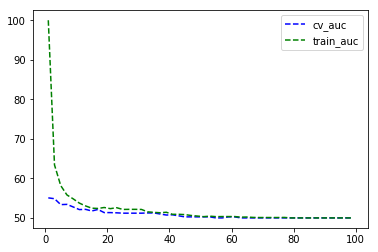

In [48]:
plt.plot([i for i in range(1,100,2)],auc_scores,'b--', label='cv_auc')
plt.plot([i for i in range(1, 100, 2)], train_auc_score,'g--', label='train_auc')
plt.legend()
plt.show()

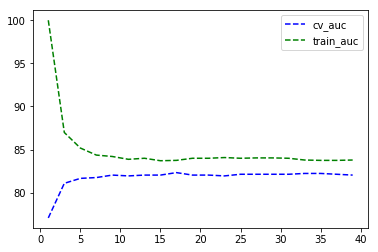

In [49]:
plt.plot([i for i in range(1,40,2)],cv_scores,'b--', label='cv_auc')
plt.plot([i for i in range(1, 40, 2)], tr_scores,'g--', label='train_auc')
plt.legend()
plt.show()

In [0]:
from sklearn.model_selection import GridSearchCV

In [51]:
# define the parameter values that should be searched
k_range = list(range(1,40,2))
print(k_range)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]


In [52]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]}


In [0]:

cnn=KNeighborsClassifier(algorithm='brute')

In [0]:
# instantiate the grid
grid = GridSearchCV(cnn, param_grid, cv=10, scoring='accuracy', return_train_score=False)

In [55]:
# fit the grid with data
grid.fit(xbow_train, ybow_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [56]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8329512893982808
{'n_neighbors': 35}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')


In [57]:
cvk_scores=[]
knn=KNeighborsClassifier(n_neighbors=15 ,algorithm='brute')#simple cross validation
#simple cross validation+
knn.fit(xbw_tr,ybw_tr)
predk=knn.predict(xbw_cv)
acck = accuracy_score(ybw_cv, predk, normalize=True) * float(100)
cvk_scores.append(acc)
print('\nCV accuracy for k = %d is %f%%' % (15, acck))
knn = KNeighborsClassifier(15)
knn.fit(xbw_tr,ybw_tr)
predk = knn.predict(xbow_test)
acck = accuracy_score(ybow_test, predk, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %d%%' % (acck))


CV accuracy for k = 15 is 82.043935%

****Test accuracy for k = 15 is 85%


In [58]:
trains_auc_score=[]
preda=knn.predict(xbow_test)
auct = roc_auc_score(ybow_test, preda) * float(100)
trains_auc_score.append(auc)
print('\n AUC on test data is %d%%' % (auct))


 AUC on test data is 53%


In [0]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ybow_test,preda)

In [60]:
cm

array([[  16,  196],
       [  17, 1267]])

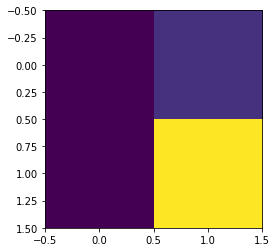

In [61]:
plt.imshow(cm)

In [62]:
xbow_train.shape

(3490, 12997)

In [0]:
knn_model=KNeighborsClassifier(n_neighbors=9 ,algorithm='brute')#ikkada nunchi

In [64]:
knn_model.fit(xbw_tr,ybw_tr)#after getting best k train the data

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [0]:
predictions=knn_model.predict(xbow_test)#predict the data

In [66]:
ybow_train.value_counts()

1    2894
0     596
Name: Score, dtype: int64

In [0]:
cmx = confusion_matrix(predictions,ybow_test)#plot confusion matrix on predictions and y test

In [68]:
cmx

array([[  20,   19],
       [ 192, 1265]])

In [0]:
import seaborn as sns

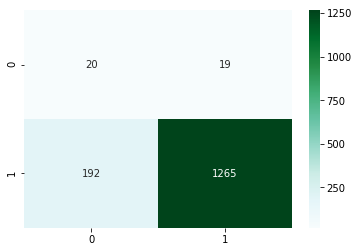

In [70]:
cm = sns.heatmap(cmx, annot = True, fmt = 'd', cmap = 'BuGn')

In [0]:
roc = roc_curve(predictions,ybow_test,pos_label=None)#wrong

In [72]:
a

NameError: ignored

In [0]:
from sklearn.metrics import roc_curve, auc

In [0]:
plt.plot(roc)

In [0]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(ybow_test, predictions)#true
roc_auc = auc(false_positive_rate, true_positive_rate)

In [0]:
false_positive_rate

In [0]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()